In [139]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

import numpy as np
import math
import pandas as pd
import itertools

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

%run code/functions.py
%run code/Build_Forms.py
None

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 30)
pd.options.display.float_format = '{:,}'.format


In [140]:
df=pd.read_csv('data/kc_house_data.csv', index_col=0)

# initial cleaning operations (splitting , etc)

df["grade"]=df["grade"].map(lambda x: x.split()[0]).astype(int)
df=df[~df["grade"].isin([3,4,5])]

df['condition'] = df['condition'].apply(enum_category)



In [149]:
# Prepairing data

df['yr_renovated'].fillna(value=df['yr_built'],inplace=True)
df['yr_renovated'] = np.where(df['yr_renovated'] == 0, df['yr_built'], df['yr_renovated'])

df['waterfront'].fillna(value='NO',inplace=True)

#NEW FEATURES

df['lat_range']=pd.cut(df['lat'], 30)
df['long_range']=pd.cut(df['long'], 30)
df['coord_range']=np.array(zip(df['lat_range'],df['long_range']))
df['decade']=pd.cut(df['yr_built'], 12)

#FILTER
#df=df[df['yr_built']>1980]



In [150]:
data_fin=pd.DataFrame([])

price=df[["price"]]

#cont=["sqft_living", 'sqft_lot', 'sqft_living15','sqft_basement']
cont=["sqft_living", 'sqft_lot']
cat=[ 'grade', 'zipcode', 'view', 'waterfront','yr_built']


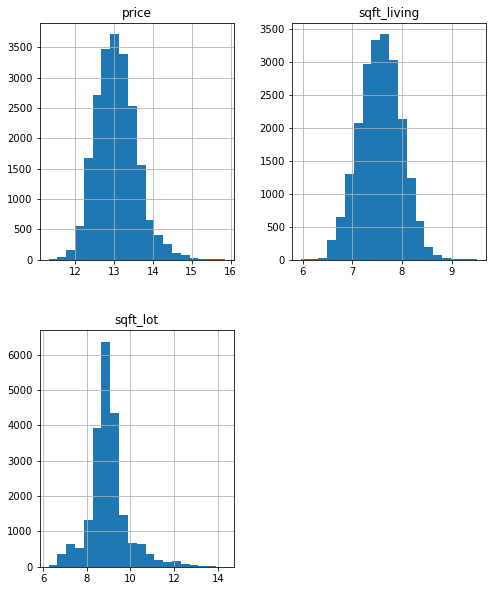

In [151]:
# Log transform and normalize
price=log_and_normalize(price, 'log', 0)
for col in cont:
    data_fin[col]=log_and_normalize(df[col], 'log', 0)


pd.concat([price, data_fin], axis=1).hist(figsize=(8,10), bins=20);




In [152]:
# One hot encode categoricals
for col in cat:
    new_cols=hot_encode(df[col], 'yes')
    data_fin = pd.concat([data_fin, new_cols], axis=1)

data_fin = pd.concat([price, data_fin], axis=1)

In [153]:
# Create OLS linear model
pred=data_fin.drop(columns=["price"]).copy()

pred_int = sm.add_constant(pred)
model = sm.OLS(price,pred_int).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     799.5
Date:                Mon, 28 Mar 2022   Prob (F-statistic):               0.00
Time:                        02:37:24   Log-Likelihood:                 6465.6
No. Observations:               21327   AIC:                        -1.253e+04
Df Residuals:                   21128   BIC:                        -1.095e+04
Df Model:                         198                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             8.5130      0.043    198.463      0.000       8.429       8.597
sqft_living       0.4478      0.005     92.761      0.000       0.438       0.457
sqft_lot          0.0756      0.002     35.099      0.000       0.071       0.080
gra_7             0.1070      0.005     20.648      0.000       0.097       0.117
gra_8             0.2114      0.006     33.852      0.000       0.199       0.224
gra_9             0.3362      0.008     43.909      0.000       0.321       0.351
gra_10            0.4411      0.009     46.931      0.000       0.423       0.460
gra_11            0.5722      0.013     45.573      0.000       0.548       0.597
gra_12            0.7040      0.022     32.501      0.000       0.662       0.747
gra_13            1.0017      0.051     19.475      0.000       0.901       1.102
zip_98002         0.0064      0.016      0.389      0.697      -0.026       0.038
zip_98003         0.0373      0.014      2.580      0.010       0.009       0.066
zip_98004         1.1578      0.014     81.123      0.000       1.130       1.186
zip_98005         0.7825      0.017     45.718      0.000       0.749       0.816
zip_98006         0.6893      0.013     53.814      0.000       0.664       0.714
zip_98007         0.7009      0.018     38.648      0.000       0.665       0.736
zip_98008         0.7002      0.015     47.841      0.000       0.671       0.729
zip_98010         0.2243      0.021     10.656      0.000       0.183       0.266
zip_98011         0.4714      0.016     29.279      0.000       0.440       0.503
zip_98014         0.2835      0.020     14.422      0.000       0.245       0.322
zip_98019         0.3158      0.016     19.321      0.000       0.284       0.348
zip_98022         0.0466      0.015      3.014      0.003       0.016       0.077
zip_98023         0.0011      0.013      0.087      0.931      -0.024       0.026
zip_98024         0.4031      0.023     17.631      0.000       0.358       0.448
zip_98027         0.5306      0.013     40.233      0.000       0.505       0.556
zip_98028         0.4280      0.014     29.670      0.000       0.400       0.456
zip_98029         0.6272      0.014     44.349      0.000       0.599       0.655
zip_98030         0.0578      0.015      3.891      0.000       0.029       0.087
zip_98031         0.1037      0.015      7.096      0.000       0.075       0.132
zip_98032        -0.0006      0.019     -0.032      0.974      -0.038       0.037
zip_98033         0.8133      0.013     62.451      0.000       0.788       0.839
zip_98034         0.5713      0.012     45.939      0.000       0.547       0.596
zip_98038         0.1770      0.012     14.469      0.000       0.153       0.201
zip_98039         1.3424      0.028     48.733      0.000       1.288       1.396
zip_98040         0.9422      0.015     63.803   

In [154]:
coef_df=model.params.reset_index()
coef_df.columns=["Column","Value"]

In [155]:
test_results=[]
for i in range(10000):
    X=np.array(df[['sqft_living','yr_built','zipcode','grade','waterfront','view', 'sqft_lot','price']].sample())[0]
    sqft_living,year,zipcode,grade,water,view,sqft_lot,price=X

#    sqft_living,year,zipcode,grade,water,view,sqft_lot,sqft_living15,price=X
#    b0,b1,b2,b3,b4,b5,b6,b7,b8 = get_coeff(year=year, zipcode=zipcode, grade=grade, water=water, view=view)
#    y=round( np.exp(b0 + b1*np.log(sqft_living) + b2 + b3 + b4 + b5 + b6 + b7*np.log(sqft_lot)+b8*np.log(sqft_living15)) )

    b0,b1,b2,b3,b4,b5,b6,b7 = get_coeff( year=year, zipcode=zipcode, grade=grade, water=water, view=view, coef_df=coef_df)
    y=round( np.exp(b0 + b1*np.log(sqft_living) + b2 + b3 + b4 + b5 + b6 + b7*np.log(sqft_lot)) )
   
    miss= np.abs(100-(y/price*100))
    test_results.append(miss)

avg_miss=sum(test_results)/len(test_results)
print (avg_miss)



13.849822977993073


In [122]:

def calculate_price (sqft_living, yr_built, zipcode, grade, waterfront, view , sqft_lot, coef_df=coef_df):
    if view == '-':
        view='NONE'

    if waterfront:
        waterfront='WATERFRONT'
    else:
        waterfront='NONE'

    b0,b1,b2,b3,b4,b5,b6,b7 = get_coeff( yr_built,zipcode,grade, waterfront, view, coef_df)
    y=round( np.exp(b0 + b1*np.log(sqft_living) + b2 + b3 + b4 + b5 + b6 + b7*np.log(sqft_lot)) )

    print(y)
    return y,b0,b1,b2,b3,b4,b5,b6,b7



In [123]:
title=form_items[0].children[0]
zipW=form_items[1].children[1]
yearW=form_items[1].children[2]
gradeW=form_items[2].children[1]
livingW=form_items[3].children[1]
lotW=form_items[4].children[1]
viewW=form_items[5].children[1]
waterW=form_items[5].children[2]
#buttonW=form_items[5].children[0]


In [124]:
#def on_button_clicked(X):
#    X=calculate_price(livingW.value, yearW.value, zipW.value,  gradeW.value, waterW.value, viewW.value, lotW.value, 'No')
#    with out:
#        output2.clear_output()
#        display("{:,}".format(X[0]))

#buttonW.on_click(on_button_clicked)  


output = widgets.interactive_output(calculate_price, {
    'zipcode': zipW, 'yr_built':yearW, 'grade':gradeW,
    'sqft_living':livingW,'sqft_lot':lotW,'view':viewW,'waterfront':waterW } )

      
ui = widgets.VBox([form, output])

output.layout={'border': '3px solid green', 'width':'150px'}

display(ui)




In [19]:
df[['sqft_living','yr_built','zipcode','grade','waterfront','view', 'sqft_lot','price']].sample()

X=calculate_price(7550,2000, 98030, 10, 'NO','NONE', 54100);
X